<a href="https://colab.research.google.com/github/cjohnsoncruz/neural_network_correlation_shuffle/blob/main/pytorch_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based off of work done by Frost Et al in PlosBiology, 2021: https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3001235

## Goal:
Develop a set of neural networks that are able to evaluate the information content contained within the correlation structure of matrices containing neural time-series

In [1]:
### Import all the necessary libraries
import scipy.io
import numpy as np
import matplotlib

from matplotlib import pyplot as plt
from matplotlib import pyplot as plt

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms, utils
from torchvision.utils import save_image
from torchvision.transforms import ToTensor


from google.colab import drive
drive.mount('/content/drive')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using cpu device


In [2]:
#CREATE A FUNCTION TAHT PERFORMS SHARC, compare to swap
def do_sharc_shuffle():
      #each raster is equivalent to a collection of blocks of activity. Each block of activity is defined by the time at which it begins, its duration, and the neuron which is active.  
  activity_blocks = list()
  block_info = {'begin':[], 'duration':[], 'ID':[]}
  pass

def do_swap_shuffle():
    pass

def create_empty_corr_matrix(raster):
        #INPUT: raster (neuron x frame input)
  og_corrs = np.corrcoef(raster)
  new_corrs = np.zeros(og_corrs.shape)
  return new_corrs
    #activity blocks must contain 1) a begin time 2) a duration and 3) neuron ID
    #each dict can contain all 3 
    #SHARC is an iterative method for generating surrogate datasets.
    
    #SHARC nonrandomly shuffles blocks of activity within a raster to generate a new (surrogate) raster in which the pairwise correlations between neurons match a target correlation matrix

In [3]:
# create class for framewise activity 
class raster_dataset(Dataset):
  """ neuron dataset"""
  def __init__(self, mat_filename, transform = None):
    mat = scipy.io.loadmat(mat_filename);
    self.spikes = torch.from_numpy(mat['spikes']) #convert numpy array of raster to tensor 
    self.transform = transform
  def __len__(self):
    return self.spikes.shape[1]

  def __getitem__(self, index):
    sample = self.spikes[:,index]
    return sample 

  def get_slice(self, index):
    return self.spikes[:, index]

  def get_sub_slice(self, row_index, col_index):
    return self.spikes[row_index, col_index]

#create class to store information on feature vector
class feature_vec(Dataset):

  def __init__(self, labels):
    self.labels = torch.from_numpy(labels) #transform label vector into tensor

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, indx):
    return self.labels[indx]


def make_rand_labels(label_len):
  rand_vec = np.random.rand(1, label_len) >= 0.5
  return rand_vec.astype(int)

class label_raster_dataset(Dataset):
  """ combined label raster dataset""" 
  def __init__(self, raster, labels):
    self.raster = raster.spikes
    self.labels = labels.labels 
    self.num_neurons = self.raster.shape[0]
  
  def __len__(self):
    return self.labels.shape[0]

  def __getitem__(self, indx):
    raster = self.raster[:,indx]
    rep = raster.shape[0] #number of times to repeat the labels to match size of raster

    label = torch.from_numpy(np.tile(self.labels[0,indx], (rep,1)))
    return raster, label #outputs tuple of tensors



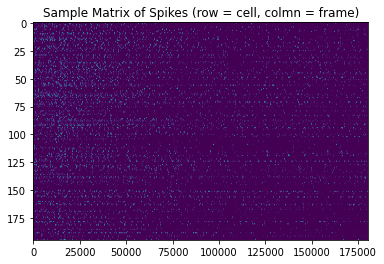

In [4]:
filename = '/content/drive/MyDrive/sampleMat.mat'
raster = raster_dataset(filename)
plt.figure();#figsize = (4,4))
plt.imshow(raster.spikes, aspect = 'auto');
plt.title('Sample Matrix of Spikes (row = cell, colmn = frame)');

In [5]:
#create random dataset for testing function of NN
rand_labels = make_rand_labels(len(raster))

rand_labels = feature_vec(rand_labels)
rand_dataset = label_raster_dataset(raster,rand_labels)

train_dataset = rand_dataset[1:100]
test_dataset = rand_dataset[200:300]

rand_dataset.num_neurons

195

In [6]:
raster.spikes.shape

torch.Size([195, 180310])

In [7]:
#build neural network
class myNet(nn.Module):
    def __init__(self, num_neurons): #input in the number of neurons you want to use 
        super(myNet, self).__init__()

        #self.encoder = nn.Sequential(nn.Linear(num_neurons,1000),nn.ReLU(),nn.Linear(1000,1),)
        self.fc1 = nn.Linear(num_neurons, 1000) #num neurons IN, 1000 OUT
        self.fc2 = nn.Linear(1000, 1) #1000 neurons in, 1 OUT
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        #create output layer

    def forward(self, x):
        #need to transpose X, as linear layers require (, Xin) shaped tensors
        x = self.fc1(x.float()) #pass 1st layer input (numNeurons ->1000),
        x = self.relu(x)#then apply relu
        x = self.fc2(x) #pass 2nd layer/output layer input (1000 ->1), 
        x = self.sigmoid(x) #then apply sigmoid for output
        return x
        

In [8]:
rand_model = myNet(rand_dataset.num_neurons)
rand_model
### Define your loss function (training criterion)
### Choose your optimizer
optimizer = optim.Adam(rand_model.parameters(), lr=0.05) #0.05 is learning rate from frost et al
loss_function = nn.BCELoss()

# gather all variables 
print("Optimizer is :", optimizer)
print("loss function is ", loss_function)
print("Device is", device)
print('model is', rand_model)

Optimizer is : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.05
    weight_decay: 0
)
loss function is  BCELoss()
Device is cpu
model is myNet(
  (fc1): Linear(in_features=195, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


Run a model on random labels and eval performance

In [49]:
def single_epoch_train(x_train, y_train, model_train, predicted, losses, loss_function, optimizer):
  for s in (train_range): 
    optimizer.zero_grad() #zero gradient before calculating for each step
    output = model_train(x_train) 
    #calculate loss
    loss = loss_function(output, y_train.unsqueeze(1).float())
    #accuracy
    predicted.append(output[0][0].item())
    #important backprop
    loss.backward()
    optimizer.step()
    losses.append(loss)
    #accur.append(acc)
    if s % 100 == 0:
      print('train ex' + str(s) + str(loss))
    return losses, predicted
    #print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

In [9]:
losses = list()
accur = list()
predicted = list()
rand_model.train() # sets the parameters to be trainable
#set training range
train_length = 1000
train_range = np.arange(1,train_length).reshape(train_length-1,1) #to get the range in the right dimensions for iteration

for s in (train_range): 
  optimizer.zero_grad() #zero gradient before calculating for each step
  x_train = torch.t(raster.spikes[:,s])  #transpose inputs to perform appropriate matrix multiplication for input layer
  y_train = rand_labels.labels[0,s]
  output = rand_model(x_train) 
  #calculate loss
  loss = loss_function(output,
                       y_train.unsqueeze(1).float())
  #accuracy
  predicted.append(output[0][0].item())
  #important backprop
  loss.backward()
  optimizer.step()
  losses.append(loss)
  #accur.append(acc)
  if s % 100 == 0:
    print('train ex' + str(s) + str(loss))
    
  #print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

train ex[100]tensor(3.5195, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[200]tensor(0.5733, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[300]tensor(0.8465, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[400]tensor(2.2261, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[500]tensor(0.0048, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[600]tensor(3.0275, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[700]tensor(0.5381, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[800]tensor(0.7536, grad_fn=<BinaryCrossEntropyBackward0>)
train ex[900]tensor(2.6306, grad_fn=<BinaryCrossEntropyBackward0>)


In [12]:
#temp placeholder function
def plot_performance(loss, predict):
  #set training range
  fig, ax = plt.subplots(2,1, figsize = (10,5))
  ax[0].plot(loss)
  ax[0].set_title('loss')
  ax[1].plot(predict);
  ax[1].set_title('predicted output');

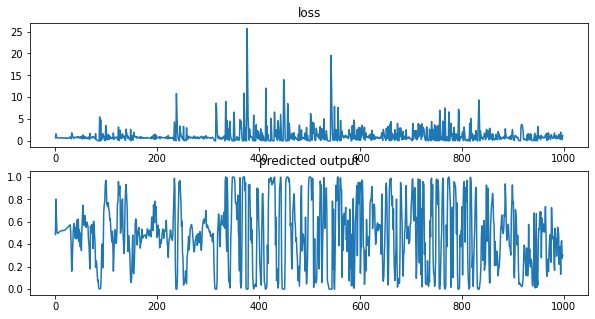

In [13]:
plot_performance(losses, predicted)

As expected, creating random labels leads to the neural network not converging to a local minima for the cost function

Now create a more structured dataset, where activity depends on the status of the boolean label. Can this network learn it?

new raster shape is(50, 180310)


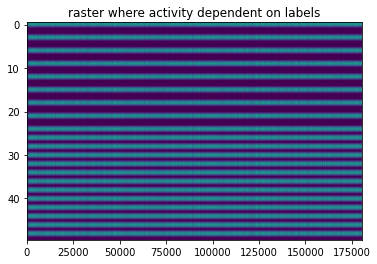

In [45]:
label_mask = rand_labels.labels[0]== 1
label_mask = label_mask.numpy() #create numpy boolean mask for indexing
d_raster_size = 50
#create raster that is dependent on random labels
dependent_raster = np.zeros((d_raster_size,len(label_mask)))
dependent_raster[0:round(d_raster_size/2):3, label_mask] = 1
dependent_raster[round(d_raster_size/2)+1::2, label_mask] = 1


print('new raster shape is' + str(dependent_raster.shape))
plt.imshow(dependent_raster, aspect = 'auto');
plt.title('raster where activity dependent on labels');

In [67]:
#create dependent_raster based model
depend_model = myNet(d_raster_size) 

### Define your loss function (training criterion)
### Choose your optimizer
learning_rate = 0.05 #0.05 is learning rate from frost et al
optimizer = torch.optim.SGD(depend_model.parameters(),lr=learning_rate)
loss_function = nn.BCELoss()

# gather all variables 
print("Optimizer is :", optimizer)
print("loss function is ", loss_function)
print("Device is", device)
print('model is', rand_model)


Optimizer is : SGD (
Parameter Group 0
    dampening: 0
    lr: 0.05
    momentum: 0
    nesterov: False
    weight_decay: 0
)
loss function is  BCELoss()
Device is cpu
model is myNet(
  (fc1): Linear(in_features=195, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


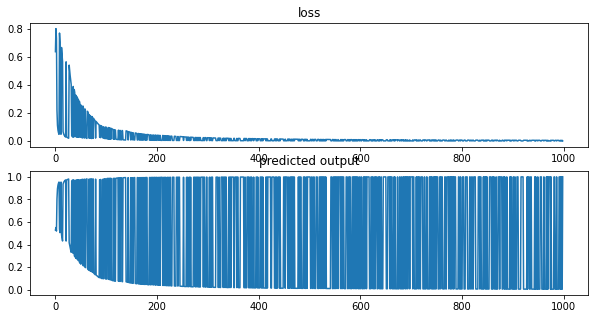

In [68]:

predictions_dict = dict()
losses_dict = dict()

predictions_dict['depend'] = []
losses_dict['depend']  = []
 #set training range
train_length = 1000
train_range = np.arange(1,train_length).reshape(train_length-1,1) #to get the range in the right dimensions for iteration
depend_model.train()

for s in (train_range): 
  optimizer.zero_grad() #zero gradient before calculating for each step
  x_train = torch.t(torch.from_numpy(dependent_raster[:,s]))  #transpose inputs to perform appropriate matrix multiplication for input layer
  y_train = rand_labels.labels[0,s]
  single_epoch_train(x_train, y_train, depend_model, predictions_dict['depend'], losses_dict['depend'], loss_function, optimizer)

plot_performance(losses_dict['depend'], predictions_dict['depend'])

As expected, a smaller neural network is able to learn the case where "neuron" activity is purely a function of the binary label vector.

